<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

# Utilizando Conv1D/LSTM/DNN com dados reais de manchas solares 

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0-dev20210819


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

/usr/bin/sh: 1: gdown: not found


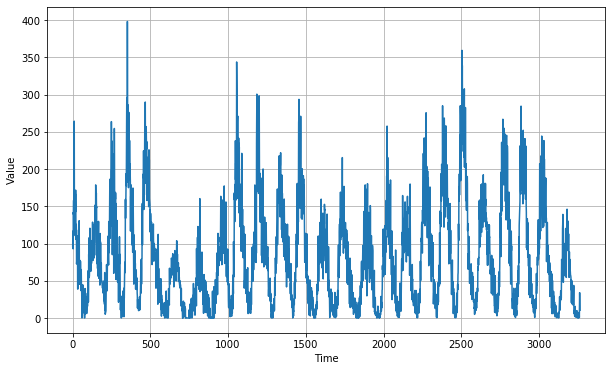

In [6]:
# Ler o csv e obter seus dados em uma lista de manchas solares e timestamps. 
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  #ignora a primeira linha, porque ela contem as definições dos conteudos do csv
  next(reader)
  for row in reader:
        #especificações no notion
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

#converter uma lista para arrays
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

'''Observe que temos sazonalidade, mas não é muito regular com alguns picos e muito mais altos do que outros. Também temos um pouco de ruído, mas não há uma tendência geral. '''

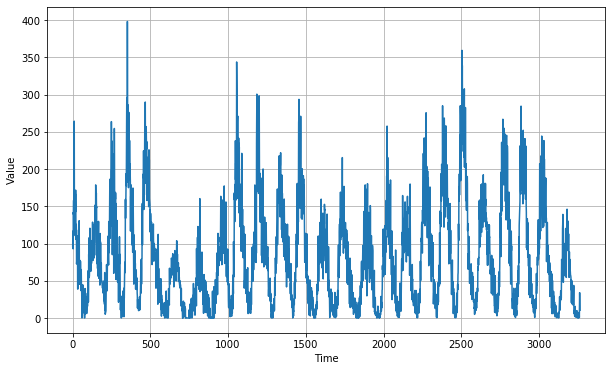

In [7]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [9]:
#Separar em dados de treinamento e de validação
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

#Teremos um tamanho de janela de 20, lote de 32 e um buffer embaralhado de 1.000.
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

'''
window_size = 60
batch_size = 64
shuffle_buffer_size = 1000
'''

'\nwindow_size = 60\nbatch_size = 64\nshuffle_buffer_size = 1000\n'

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    #convolução 1D que aprenderemos 32 filtros
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), 
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  #DNN
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  #como nossos números estão na faixa de 1 a 400, há uma camada Lambda que multiplica nosso X por 400. 
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
#LSTMs com 32 células cada um 
    '''  
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  '''

'''Depois de fazer o treinamento, pode-se perceber que a melhor taxa de aprendizado seria 10-5 or 1e-5'''

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 243ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 3s 230ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 4s 292ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 4s 265ms/step - loss: 72.2678 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 3s 260ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 3s 266ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 3s 259ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 4s 263ms/step - loss: 58.1406 - mae: 58.6369


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fe64aa29ee0>
Traceback (most recent call last):
  File "/home/bene/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 562, in __del__
    gen_dataset_ops.delete_iterator(
  File "/home/bene/.local/lib/python3.8/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1263, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


Epoch 9/100
12/12 [==============================] - 4s 263ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [==============================] - 3s 260ms/step - loss: 52.3436 - mae: 52.8399
Epoch 11/100
12/12 [==============================] - 3s 266ms/step - loss: 49.9148 - mae: 50.4112
Epoch 12/100
12/12 [==============================] - 4s 317ms/step - loss: 47.8592 - mae: 48.3560
Epoch 13/100
12/12 [==============================] - 4s 309ms/step - loss: 46.0553 - mae: 46.5517
Epoch 14/100
12/12 [==============================] - 4s 291ms/step - loss: 44.5443 - mae: 45.0406
Epoch 15/100
12/12 [==============================] - 4s 317ms/step - loss: 43.3078 - mae: 43.8045
Epoch 16/100
12/12 [==============================] - 4s 300ms/step - loss: 42.2855 - mae: 42.7826
Epoch 17/100
12/12 [==============================] - 4s 341ms/step - loss: 41.3797 - mae: 41.8767
Epoch 18/100
12/12 [==============================] - 4s 343ms/step - loss: 40.5481 - mae: 41.0453
Epoch 19/10

12/12 [==============================] - 4s 305ms/step - loss: 52.0889 - mae: 52.5873
Epoch 92/100
12/12 [==============================] - 4s 328ms/step - loss: 48.6254 - mae: 49.1229
Epoch 93/100
12/12 [==============================] - 3s 255ms/step - loss: 55.6425 - mae: 56.1400
Epoch 94/100
12/12 [==============================] - 3s 262ms/step - loss: 61.7040 - mae: 62.2023
Epoch 95/100
12/12 [==============================] - 4s 320ms/step - loss: 49.2423 - mae: 49.7403
Epoch 96/100
12/12 [==============================] - 5s 361ms/step - loss: 63.9922 - mae: 64.4907
Epoch 97/100
12/12 [==============================] - 4s 339ms/step - loss: 55.5680 - mae: 56.0662
Epoch 98/100
12/12 [==============================] - 4s 302ms/step - loss: 122.4766 - mae: 122.9759
Epoch 99/100
12/12 [==============================] - 4s 287ms/step - loss: 85.2665 - mae: 85.7654
Epoch 100/100
12/12 [==============================] - 4s 290ms/step - loss: 56.8872 - mae: 57.3855


'Depois de fazer o treinamento, pode-se perceber que a melhor taxa de aprendizado seria 10-5 or 1e-5'

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
#O MAE do professor deu 14.456. Mas quando olhou o grafico de perda, viu que tinha muito ruido
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)